In [1]:
import numpy as np
import pandas as pd
import duckdb
import sqlalchemy
import matplotlib.pyplot as plt
import geopandas as gpd

In [2]:
# Connect to DuckDB
con = duckdb.connect("duckdb/br_temp.db")

# Load each table into a separate DataFrame
dim_customers = con.execute("SELECT * FROM olist.dim_customers").fetchdf()
dim_payments = con.execute("SELECT * FROM olist.dim_payments").fetchdf()
dim_reviews = con.execute("SELECT * FROM olist.dim_reviews").fetchdf()
dim_geolocation = con.execute("SELECT * FROM olist.dim_geolocation").fetchdf()
dim_items = con.execute("SELECT * FROM olist.dim_items").fetchdf()
dim_date = con.execute("SELECT * FROM olist.dim_date").fetchdf()
fct_orders = con.execute("SELECT * FROM olist.fct_orders").fetchdf()


In [3]:
dim_customers.head()

,customer_sid,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,load_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,2025-06-07 10:08:38 AM
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,09790,sao bernardo do campo,SP,2025-06-07 10:08:38 AM
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,01151,sao paulo,SP,2025-06-07 10:08:38 AM
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,08775,mogi das cruzes,SP,2025-06-07 10:08:38 AM
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,2025-06-07 10:08:38 AM


In [4]:
dim_items.head()

,item_sid,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_category_name_english,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,cool_stuff,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,27277,volta redonda,SP
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,pet_shop,pet_shop,56.0,239.0,2.0,30000.0,50.0,30.0,40.0,03471,sao paulo,SP
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,moveis_decoracao,furniture_decor,59.0,695.0,2.0,3050.0,33.0,13.0,33.0,37564,borda da mata,MG
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,perfumaria,perfumery,42.0,480.0,1.0,200.0,16.0,10.0,15.0,14403,franca,SP
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,ferramentas_jardim,garden_tools,59.0,409.0,1.0,3750.0,35.0,40.0,30.0,87900,loanda,PR


In [ ]:
def check_one_to_one_mapping(df, key_col, value_cols):
    combo_counts = df.groupby(key_col)[value_cols].nunique()

    # Keep rows where there's more than 1 unique combinations for any value_col
    inconsistent_keys = combo_counts[(combo_counts > 1).any(axis=1)]

    if not inconsistent_keys.empty:
        print(f" {key_col} has non-unique combinations of {value_cols} :")
        return df[df[key_col].isin(inconsistent_keys.index)].sort_values(key_col)
    else:
        print(f"Each '{key_col}' maps uniquely to combinations of {value_cols}.")


In [6]:
check_one_to_one_mapping(dim_geolocation,"geolocation_zip_code_prefix", ["geolocation_lat", "geolocation_lng"] )

 geolocation_zip_code_prefix has non-unique combinations of ['geolocation_lat', 'geolocation_lng'] :


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
278917,01001,-23.549779,-46.633957,sao paulo,SP
93514,01001,-23.549292,-46.633559,sao paulo,SP
647684,01001,-23.550642,-46.634410,sao paulo,SP
186040,01001,-23.549779,-46.633957,são paulo,SP
463454,01001,-23.551337,-46.634027,sao paulo,SP
...,...,...,...,...,...
483660,99980,-28.390507,-51.847413,david canabarro,RS
21871,99980,-28.386408,-51.844876,david canabarro,RS
391715,99980,-28.386239,-51.847741,david canabarro,RS
21867,99990,-28.329472,-51.769109,muliterno,RS


It appears that one zip code can have different combinations of longtitude latittude, source states that the zip code is the first 5 digits.

Therefore, longtitude and latitude will be used as variables for heatmaps for this dataset

<div class="alert alert-block alert-info">
Exploration of data:

In [ ]:
#get buyer city + orders in df
orders_customers = pd.merge(
    fct_orders,
    dim_customers,
    how='left',
    left_on='customer_sid',
    right_on='customer_sid'
)

#if prices are needed
orders_full = pd.merge(
    orders_customers,
    dim_items[['item_sid', 'price']],
    how='left',
    left_on='item_sid',
    right_on='item_sid'
)

In [ ]:
orders_customers['order_purchase_timestamp'] = pd.to_datetime(orders_customers['order_purchase_timestamp'])
orders_customers['year_month'] = orders_full['order_purchase_timestamp'].dt.to_period('M')

In [ ]:
monthly_city_sales = orders_customers.groupby(['customer_city', 'year_month'])['TOTAL_PAYMENT'].sum().reset_index()

In [ ]:
monthly_city_sales['year_month'].value_counts().sort_index(ascending=False)

year_month
2018-10       3
2018-09      13
2018-08    1270
2018-07    1262
2018-06    1257
2018-05    1337
2018-04    1326
2018-03    1383
2018-02    1325
2018-01    1364
2017-12    1201
2017-11    1421
2017-10    1111
2017-09    1012
2017-08    1006
2017-07     973
2017-06     817
2017-05     940
2017-04     696
2017-03     772
2017-02     576
2017-01     381
2016-12       1
2016-10     183
2016-09       4
Freq: M, Name: count, dtype: int64

In [ ]:
monthly_city_sales[monthly_city_sales['year_month'] == "2018-09"]

,customer_city,year_month,TOTAL_PAYMENT
1954,barra do pirai,2018-09,55.00
2290,belo horizonte,2018-09,729.82
3678,campina verde,2018-09,46.20
9052,itaguai,2018-09,432.32
10426,joinville,2018-09,52.25
11993,maua,2018-09,390.77
13018,nova friburgo,2018-09,84.20
14967,pirai,2018-09,548.45
17621,santo andre,2018-09,236.80
17807,santos,2018-09,94.40


Comments:

It is interesting to see very few records for sales on 2018-09, 2018-10. It might be beneficial to verify data collection methods during these 2 months.

data frame for top 5 cities (monthly sales) 

In [ ]:
city_no_filter = 5
top_cities = (monthly_city_sales.groupby('customer_city')['TOTAL_PAYMENT'].sum().sort_values(ascending=False).head(city_no_filter))
top_cities = top_cities.index.tolist()
top_cities

['sao paulo', 'rio de janeiro', 'belo horizonte', 'brasilia', 'curitiba']

In [ ]:
top_city_sales = monthly_city_sales[monthly_city_sales['customer_city'].isin(top_cities)]

In [14]:
#shift customer_city to columns
pivot_df = top_city_sales.pivot(index='year_month', columns='customer_city', values='TOTAL_PAYMENT')
pivot_df.head()

customer_city,belo horizonte,brasilia,curitiba,rio de janeiro,sao paulo
year_month,,,,,
2016-09,NaN,NaN,NaN,NaN,28.75
2016-10,1238.20,2360.34,1389.73,3019.85,6484.75
2017-01,2373.44,2162.21,1099.71,11930.12,17999.69
2017-02,5568.46,4602.81,4434.23,24309.30,36128.62
2017-03,12219.22,6139.84,6124.72,33941.80,57865.96


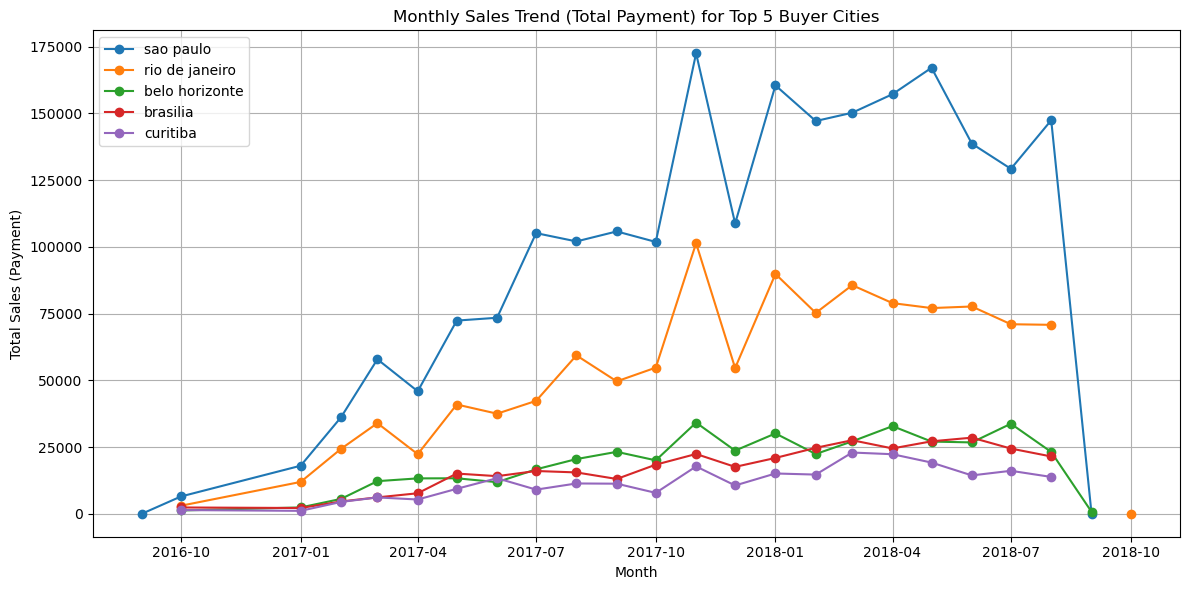

In [ ]:
plt.figure(figsize=(12, 6))
for city in top_cities:
    plt.plot(pivot_df.index.to_timestamp(), pivot_df[city], marker='o', label=city)

plt.title('Monthly Sales Trend (Total Payment) for Top 5 Buyer Cities')
plt.xlabel('Month')
plt.ylabel('Total Sales (Payment)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In the time period between between 2017-10 and 2018-01 there was a shearp spike in monthly sales

In [16]:
#investigating variances seen between 2017-10 and 2018-01

fct_orders['order_purchase_timestamp'] = pd.to_datetime(fct_orders['order_purchase_timestamp'])

# Filter to delivered orders and desired date range
mask = (
    (fct_orders['order_status'] == 'delivered') &
    (fct_orders['order_purchase_timestamp'] >= '2017-10-01') &
    (fct_orders['order_purchase_timestamp'] <= '2018-01-31')
)
daily_sales = fct_orders[mask].groupby('order_purchase_timestamp')['TOTAL_PAYMENT'].sum().reset_index()
daily_sales.head()

,order_purchase_timestamp,TOTAL_PAYMENT
0,2017-10-01 00:03:33,42.78
1,2017-10-01 00:06:09,203.14
2,2017-10-01 00:15:12,61.01
3,2017-10-01 00:19:04,52.78
4,2017-10-01 01:10:18,525.09


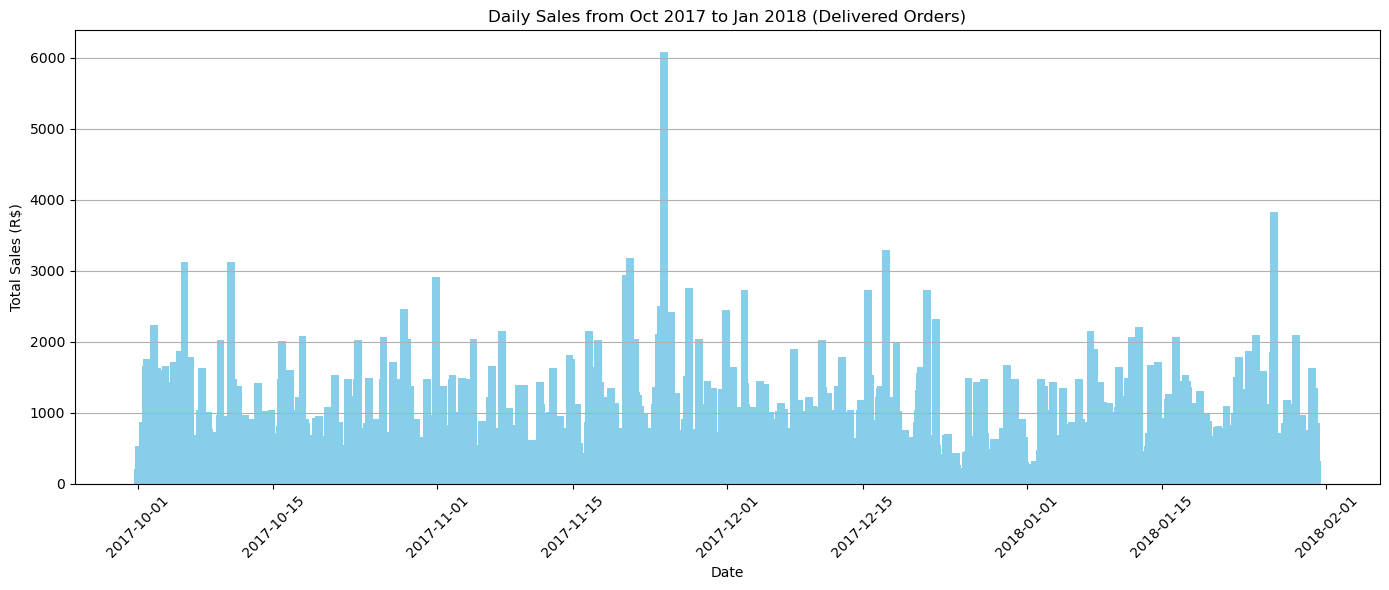

In [17]:
plt.figure(figsize=(14, 6))
plt.bar(daily_sales['order_purchase_timestamp'], daily_sales['TOTAL_PAYMENT'], color='skyblue')
plt.title('Daily Sales from Oct 2017 to Jan 2018 (Delivered Orders)')
plt.xlabel('Date')
plt.ylabel('Total Sales (R$)')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Comments:

Nov 24th was black friday in brazil for year 2017, so there was a significant increase in sales in the middle of this time period between 2017-10 and 2018-01 

In [18]:
#filter only delivered orders
delivered_orders = fct_orders[fct_orders['order_status'] == 'delivered']
#merge to get customer zip_code
orders_with_zip = pd.merge(delivered_orders, dim_customers[['customer_sid', 'customer_zip_code_prefix']], how='left',on='customer_sid')

#merge to get latitude and longitude
orders_with_geo = pd.merge(
    orders_with_zip,
    dim_geolocation[['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng']],
    how='left',
    left_on='customer_zip_code_prefix',
    right_on='geolocation_zip_code_prefix'
)

geo_sales_heatmap = orders_with_geo.groupby(['geolocation_lat', 'geolocation_lng'])['TOTAL_PAYMENT'].sum().reset_index()
geo_sales_heatmap.head()


,geolocation_lat,geolocation_lng,TOTAL_PAYMENT
0,-36.605374,-64.283946,1506.27
1,-36.603837,-64.287433,1506.27
2,-34.622400,-58.901888,196.40
3,-34.586422,-58.732101,24.11
4,-33.692616,-53.453972,908.16


In [19]:
geo_sales_heatmap.max()

geolocation_lat       43.684961
geolocation_lng       13.820214
TOTAL_PAYMENT      56624.420000
dtype: float64

In [20]:
geo_sales_heatmap.min()

geolocation_lat    -36.605374
geolocation_lng   -101.466766
TOTAL_PAYMENT       17.640000
dtype: float64

brazil's longtitude range is -74 to -34

Latitude: from -34 to +5

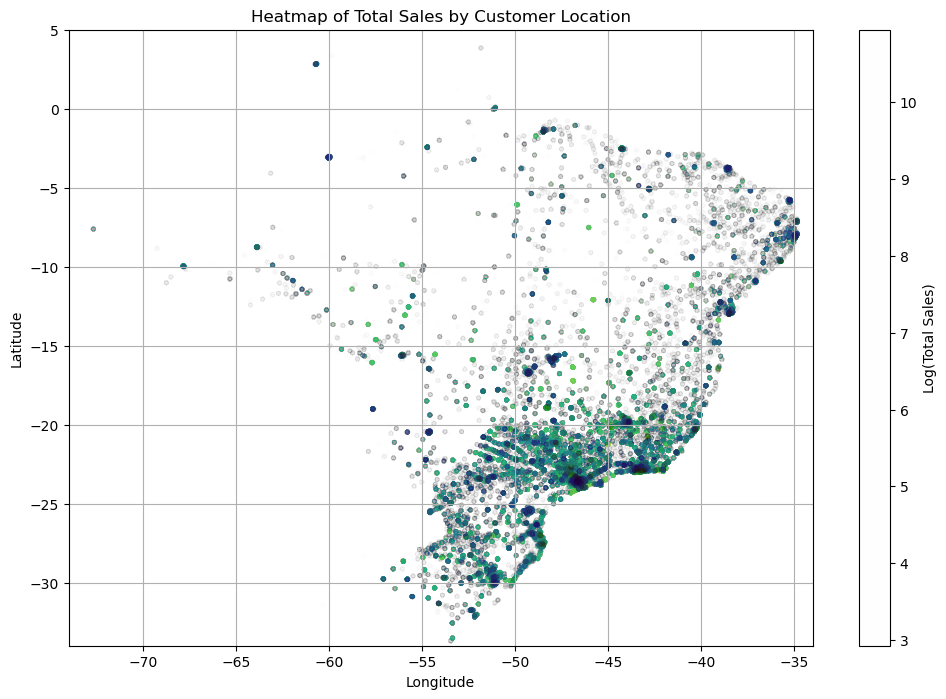

In [21]:
plt.figure(figsize=(12, 8))

scatter = plt.scatter(
    geo_sales_heatmap['geolocation_lng'],
    geo_sales_heatmap['geolocation_lat'],
    c=np.log1p(geo_sales_heatmap['TOTAL_PAYMENT']),
    s=10,
    alpha=0.002
)

plt.colorbar(scatter).set_label('Log(Total Sales)')

plt.title('Heatmap of Total Sales by Customer Location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Brazil boundary for longtitude and latitude
plt.xlim([-74, -34])
plt.ylim([-34, 5])

plt.grid(True)
plt.show()

This heatmap is the heatmap of customers in brazil, which plots longtitude vs latitude vs total sales.

The intensity or shades of color indicate a higher number of sales in that area.

As we can see from the heatap. a lot of dots are concentrated at south west of Brazil.

log(1+ sales) is used instead to make differences more visually distinct.

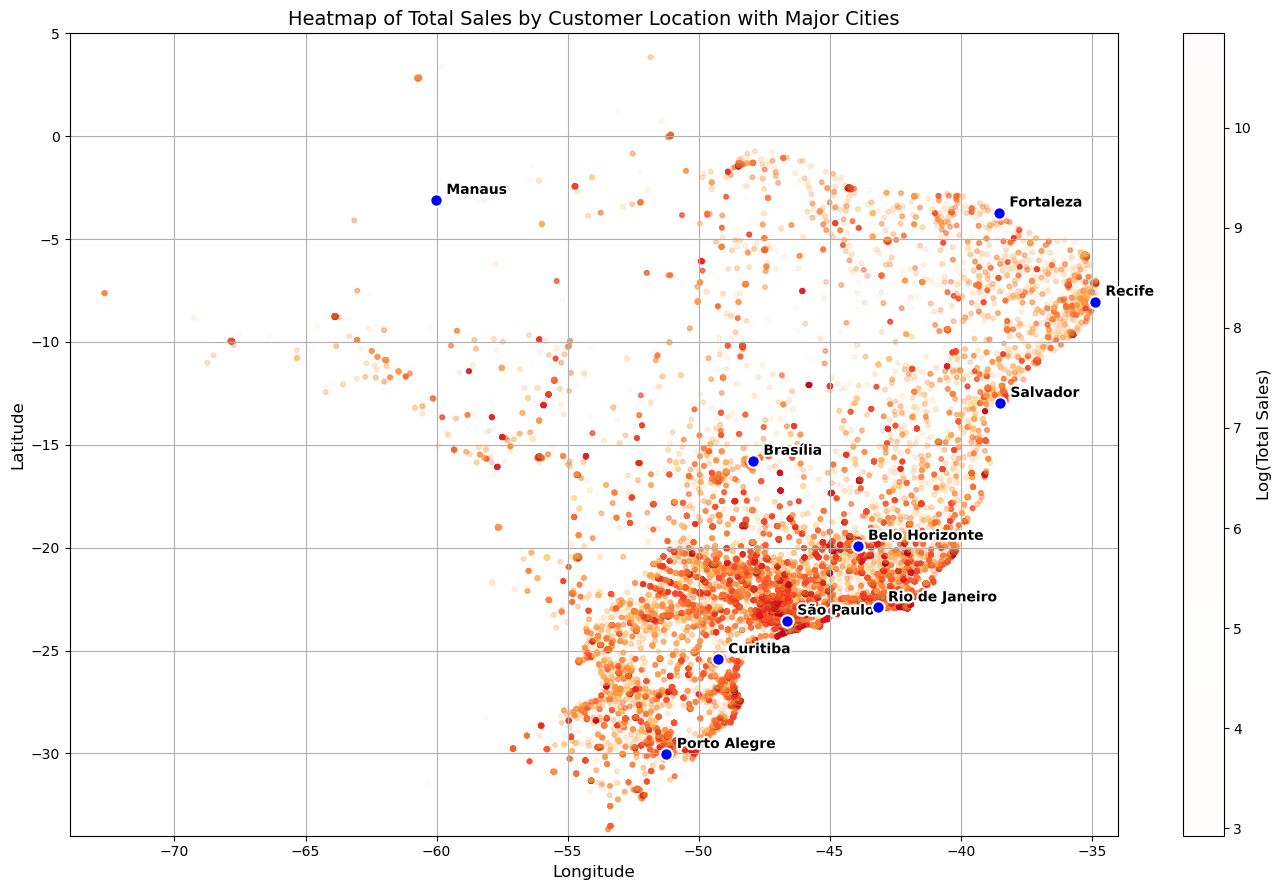

In [22]:

import matplotlib.patheffects as pe

brazil_cities = {
    'São Paulo': (-46.6333, -23.5505),
    'Rio de Janeiro': (-43.1729, -22.9068),
    'Brasília': (-47.9292, -15.7801),
    'Salvador': (-38.5011, -12.9714),
    'Fortaleza': (-38.5433, -3.7172),
    'Manaus': (-60.0258, -3.1019),
    'Curitiba': (-49.2731, -25.4284),
    'Recife': (-34.8770, -8.0476),
    'Porto Alegre': (-51.2300, -30.0346),
    'Belo Horizonte': (-43.9345, -19.9167)
}

plt.figure(figsize=(14, 9))

# heatmap of sales
scatter = plt.scatter(
    geo_sales_heatmap['geolocation_lng'],
    geo_sales_heatmap['geolocation_lat'],
    c=np.log1p(geo_sales_heatmap['TOTAL_PAYMENT']),
    cmap='YlOrRd',
    s=10,
    alpha=0.02
)


plt.colorbar(scatter).set_label('Log(Total Sales)', fontsize=12)
plt.title('Heatmap of Total Sales by Customer Location with Major Cities', fontsize=14)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.xlim([-74, -34])
plt.ylim([-34, 5])
plt.grid(True)

# Mark cities
for city, (lon, lat) in brazil_cities.items():
    plt.scatter(lon, lat, color='blue', marker='o', s=80, edgecolors='white', linewidths=1.5, zorder=5)
    plt.text(
        lon + 0.4, lat + 0.3, city,
        fontsize=10,
        color='black',
        weight='bold',
        path_effects=[pe.withStroke(linewidth=3, foreground="white")]
    )

plt.tight_layout()
plt.show()

brazil map from :

wget https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson -O brazil-states.geojson

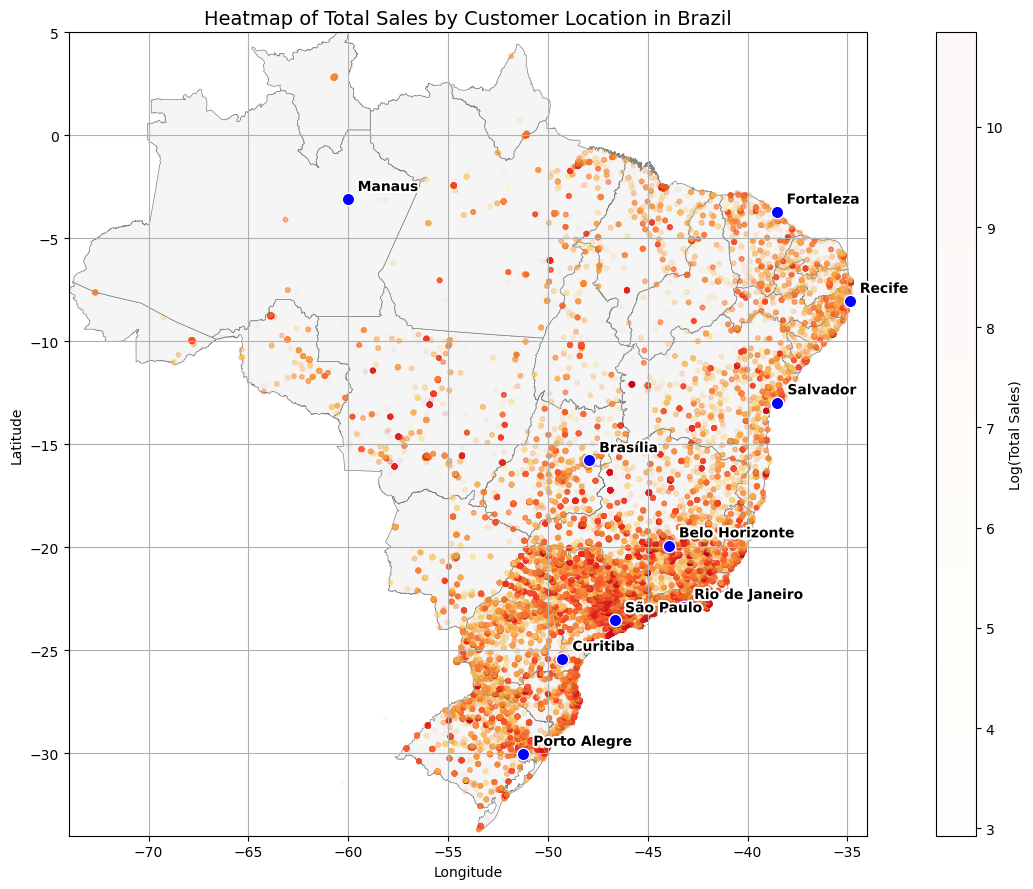

In [23]:
import matplotlib.patheffects as pe

# Load Brazil GeoJSON
brazil = gpd.read_file("brazil-states.geojson")

fig, ax = plt.subplots(figsize=(14, 9))

# Plot Brazil state boundaries
brazil.plot(ax=ax, color='whitesmoke', edgecolor='grey', linewidth=0.5, zorder=0)

scatter = ax.scatter(
    geo_sales_heatmap['geolocation_lng'],
    geo_sales_heatmap['geolocation_lat'],
    c=np.log1p(geo_sales_heatmap['TOTAL_PAYMENT']),
    cmap='YlOrRd',
    s=10,
    alpha=0.03,
    zorder=1
)
plt.colorbar(scatter, ax=ax, label='Log(Total Sales)')

# Plot major cities
brazil_cities = {
    'São Paulo': (-46.6333, -23.5505),
    'Rio de Janeiro': (-43.1729, -22.9068),
    'Brasília': (-47.9292, -15.7801),
    'Salvador': (-38.5011, -12.9714),
    'Fortaleza': (-38.5433, -3.7172),
    'Manaus': (-60.0258, -3.1019),
    'Curitiba': (-49.2731, -25.4284),
    'Recife': (-34.8770, -8.0476),
    'Porto Alegre': (-51.2300, -30.0346),
    'Belo Horizonte': (-43.9345, -19.9167)
}
for city, (lon, lat) in brazil_cities.items():
    ax.scatter(lon, lat, color='blue', edgecolor='white', s=80, zorder=2)
    ax.text(lon + 0.5, lat + 0.4, city,
            fontsize=10, color='black', weight='bold',
            path_effects=[pe.withStroke(linewidth=3, foreground="white")],
            zorder=3)

ax.set_title("Heatmap of Total Sales by Customer Location in Brazil", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_xlim([-74, -34])
ax.set_ylim([-34, 5])
plt.grid(True)
plt.tight_layout()
plt.show()

This heatmap is the heatnap of sales of customers in brazil with city names, country boundaries. A high concentration of the customers orders come from Sao paulo. 

In [24]:
orders_full.columns

Index(['payment_sid', 'review_sid', 'item_sid', 'customer_sid', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'TOTAL_PAYMENT', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'load_date', 'price'],
      dtype='object')

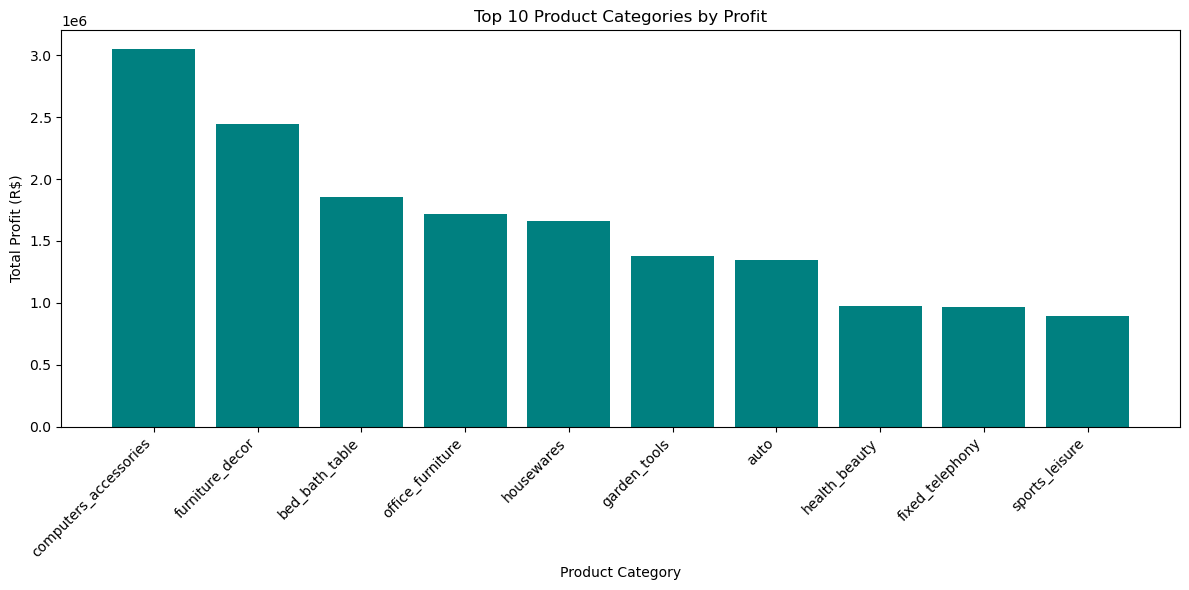

In [25]:
orders_full['profit'] = orders_full['TOTAL_PAYMENT'] - orders_full['price']

orders_full = orders_full.merge(
    dim_items[['item_sid', 'product_category_name_english']],
    on='item_sid',
    how='left'
)
# Group by category and sum profit
category_profit = orders_full.groupby('product_category_name_english')['profit'].sum().reset_index()

#top 10 ctageories
top10_cat_profit = category_profit.sort_values('profit', ascending=False).head(10)

# Plot bar chart
plt.figure(figsize=(12,6))
plt.bar(top10_cat_profit['product_category_name_english'], top10_cat_profit['profit'], color='teal')
plt.xlabel('Product Category')
plt.ylabel('Total Profit (R$)')
plt.title('Top 10 Product Categories by Profit')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

This chart shows the top 10 product categories for profit made.(derived column)

This chart shows that among the computer accessories and auto yield significantly higher profits.